In [1]:
from os import listdir
from os.path import isfile, join
import  numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_path_final = 'data/final_resized'
data_path_orig = 'data/capture'
data_path_lp = 'data/perturbed_light'
data_path_occl = 'data/perturbed_occl'
data_path_orig_GT = 'data/capture_GT'
data_path_lp_GT = 'data/perturbed_light_GT'
data_path_occl_GT = 'data/perturbed_occl_GT'

In [3]:
orig_GT = np.loadtxt(join(data_path_orig_GT, 'captured_GT.csv'), dtype = np.float32)[1:]
lp_GT = np.loadtxt(join(data_path_lp_GT, 'light_perturbed_GT.csv'), dtype = np.float32)
occl_GT = np.loadtxt(join(data_path_occl_GT, 'occl_perturbed_GT.csv'), dtype = np.float32)
print(orig_GT.shape)
print(lp_GT.shape)
print(occl_GT.shape)

(29999, 6)
(1500, 6)
(1500, 6)


In [4]:
files_orig = [join(data_path_orig, i) for i in listdir(data_path_orig)]
files_lp = [join(data_path_lp, i) for i in listdir(data_path_lp)]
files_occl = [join(data_path_occl, i) for i in listdir(data_path_occl)]
print(len(files_orig))
print(len(files_lp))
print(len(files_occl))

29999
1500
1500


(512, 512, 3)
(128, 128, 3)


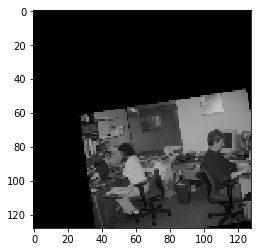

In [5]:
sample_img = cv2.imread(join(files_orig[0]))
print(sample_img.shape)
img_shape = sample_img.shape
resized = cv2.resize(sample_img, (128, 128))
print(resized.shape)
plt.imshow(sample_img)
plt.imshow(resized)

In [6]:
new_height = 128
new_width = 128

In [7]:
train_part_idx_orig = int(len(files_orig) * 0.8)
train_part_idx_perturbed = int(len(files_lp) * 0.8)
print(train_part_idx_orig)

23999


In [ ]:
#train_imgs_orig = np.zeros([len(files_orig[train_part_idx_orig:]), img_shape[0], img_shape[1], img_shape[2]], dtype='uint')
# train_imgs_lp = np.zeros([len(files_lp[:train_part_idx_perturbed]), img_shape[0], img_shape[1], img_shape[2]], dtype='uint')
# train_imgs_occl = np.zeros([len(files_occl[:train_part_idx_perturbed]), img_shape[0], img_shape[1], img_shape[2]], dtype='uint')
# test_imgs_orig = np.zeros([len(files_orig[train_part_idx_orig:]), img_shape[0], img_shape[1], img_shape[2]], dtype='uint')
# test_imgs_lp = np.zeros([len(files_lp[train_part_idx_perturbed:]), img_shape[0], img_shape[1], img_shape[2]], dtype='uint')
# test_imgs_occl = np.zeros([len(files_lp[train_part_idx_perturbed:]), img_shape[0], img_shape[1], img_shape[2]], dtype='uint')

In [12]:
train_size = train_part_idx_orig + 2 * train_part_idx_perturbed
test_size = (len(files_orig) - train_part_idx_orig) + 2 * (len(files_lp) - train_part_idx_perturbed)
print(train_size)
print(test_size)

26399
6600


In [13]:
# train_shape = (train_size, img_shape[0], img_shape[1], img_shape[2])
# test_shape = (test_size, img_shape[0], img_shape[1], img_shape[2])
train_shape = (train_size, new_height, new_width, 3)
test_shape = (test_size, new_height, new_width, 3)
print(train_shape)
print(test_shape)

(26399, 128, 128, 3)
(6600, 128, 128, 3)


In [14]:
all_train_files = files_orig[:train_part_idx_orig] + files_lp[:train_part_idx_perturbed] + files_occl[:train_part_idx_perturbed]
all_test_files = files_orig[train_part_idx_orig:] + files_lp[train_part_idx_perturbed:] + files_occl[train_part_idx_perturbed:]
print(len(all_train_files))
print(len(all_test_files))

26399
6600


In [15]:
all_train_GT = np.vstack((orig_GT[:train_part_idx_orig], lp_GT[:train_part_idx_perturbed], occl_GT[:train_part_idx_perturbed]))
all_test_GT = np.vstack((orig_GT[train_part_idx_orig:], lp_GT[train_part_idx_perturbed:], occl_GT[train_part_idx_perturbed:]))

print(all_train_GT.shape)
print(all_test_GT.shape)

(26399, 6)
(6600, 6)


In [16]:
rand_idx_train = np.random.choice(np.arange(train_size), size=train_size, replace=False)
rand_idx_test = np.random.choice(np.arange(test_size), size=test_size, replace=False)

all_train_files_rand = [all_train_files[i] for i in rand_idx_train]
all_test_files_rand = [all_test_files[i] for i in rand_idx_test]
all_train_GT_rand = all_train_GT[rand_idx_train, :]
all_test_GT_rand = all_test_GT[rand_idx_test, :]

In [17]:
print(len(all_train_files_rand))
print(len(all_test_files_rand))
print(all_train_GT_rand.shape)
print(all_test_GT_rand.shape)

26399
6600
(26399, 6)
(6600, 6)


In [18]:
h5_file_train = h5py.File(join(data_path_final, 'train_set.hdf5'), mode='w')
h5_file_train.create_dataset('train_img', train_shape, np.int8)

<HDF5 dataset "train_img": shape (26399, 128, 128, 3), type "|i1">

In [20]:
for i in range(train_size):
    addr = join(all_train_files_rand[i])
    img = cv2.imread(addr)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, (new_height, new_width)) # use if you want to resize images 
    #h5_file_train['train_img'][i,...] = img[None]
    h5_file_train['train_img'][i,...] = resized_img[None] #while storing resized images
    
h5_file_train.close()

In [21]:
h5_file_test = h5py.File(join(data_path_final, 'test_set.hdf5'), mode='w')
h5_file_test.create_dataset('test_img', test_shape, np.int8)

<HDF5 dataset "test_img": shape (6600, 128, 128, 3), type "|i1">

In [23]:
for i in range(test_size):
    addr = all_test_files_rand[i]
    img = cv2.imread(addr)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, (new_height, new_width))
    #h5_file_test['test_img'][i,...] = img[None]
    h5_file_test['test_img'][i,...] = resized_img[None]
      
h5_file_test.close()

In [24]:
np.savetxt(join(data_path_final, 'train_GT.csv'), all_train_GT_rand, delimiter='\t')
np.savetxt(join(data_path_final, 'test_GT.csv'), all_test_GT_rand, delimiter='\t')